In [1]:
# %pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install ensemble_boxes
# %pip install albumentations
# %pip install effdet
# %pip install natsort
#%pip install nibabel

## Imports

In [2]:
import sys
from ensemble_boxes import *
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from matplotlib import pyplot as plt
import torch.nn as nn
import os
from datetime import datetime
import time
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import natsort as ns
import re
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict
from effdet.efficientdet import HeadNet
from torch.utils.data import Dataset
import nibabel as nib
from sklearn.model_selection import train_test_split

# For testing only
from albumentations import Compose, Normalize, Resize, BboxParams
from omegaconf import OmegaConf
# from fitter import Fitter

c:\Users\nigel\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Print all the cases available in the dataset

In [3]:
import os

testing_label_relative = 'VALDO_Dataset\Task2'
current_directory = os.getcwd()

two_directories_up = os.path.abspath(os.path.join(current_directory, "../"))

# Combine the current directory with the relative path
testing_label_absolute = os.path.join(two_directories_up, testing_label_relative)

folders = [item for item in os.listdir(testing_label_absolute) if os.path.isdir(os.path.join(testing_label_absolute, item))]

cases = {"cohort1": [], "cohort2": [], "cohort3": []}
# Print the list of folders
for folder in folders:
    if "sub-1" in folder:
        cases["cohort1"].append(folder)
    elif "sub-2" in folder:
        cases["cohort2"].append(folder)
    else:
        cases["cohort3"].append(folder)

cases

{'cohort1': ['sub-101',
  'sub-102',
  'sub-103',
  'sub-104',
  'sub-105',
  'sub-106',
  'sub-107',
  'sub-108',
  'sub-109',
  'sub-110',
  'sub-111'],
 'cohort2': ['sub-201',
  'sub-202',
  'sub-203',
  'sub-204',
  'sub-205',
  'sub-206',
  'sub-207',
  'sub-208',
  'sub-209',
  'sub-210',
  'sub-211',
  'sub-212',
  'sub-213',
  'sub-214',
  'sub-215',
  'sub-216',
  'sub-217',
  'sub-218',
  'sub-219',
  'sub-220',
  'sub-221',
  'sub-222',
  'sub-223',
  'sub-224',
  'sub-225',
  'sub-226',
  'sub-227',
  'sub-228',
  'sub-229',
  'sub-230',
  'sub-231',
  'sub-232',
  'sub-233',
  'sub-234'],
 'cohort3': ['sub-301',
  'sub-302',
  'sub-303',
  'sub-304',
  'sub-305',
  'sub-306',
  'sub-307',
  'sub-308',
  'sub-309',
  'sub-310',
  'sub-311',
  'sub-312',
  'sub-313',
  'sub-314',
  'sub-315',
  'sub-316',
  'sub-317',
  'sub-318',
  'sub-319',
  'sub-320',
  'sub-321',
  'sub-322',
  'sub-323',
  'sub-324',
  'sub-325',
  'sub-326',
  'sub-327']}

## Divide the available cases according to cohorts

In [4]:
cohort1_labels = []
cohort1_ids = []
for case in cases["cohort1"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort1_labels.append(label)
    cohort1_ids.append(id)
# print("Label:", cohort1_labels, cohort1_labels.__len__())
# print("Ids:", cohort1_ids, cohort1_ids.__len__())

cohort2_labels = []
cohort2_ids = []
for case in cases["cohort2"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort2_labels.append(label)
    cohort2_ids.append(id)
# print("Label:", cohort2_labels, cohort2_labels.__len__())
# print("Ids:", cohort2_ids, cohort2_ids.__len__())

cohort3_labels = []
cohort3_ids = []
for case in cases["cohort3"]:
    label = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_CMB.nii.gz"
    id = f"{testing_label_absolute}\\{case}\\{case}_space-T2S_desc-masked_T2S.nii.gz"
    cohort3_labels.append(label)
    cohort3_ids.append(id)
# print("Label:", cohort3_labels, cohort3_labels.__len__())
# print("Ids:", cohort3_ids, cohort3_ids.__len__())

all_labels = cohort1_labels + cohort2_labels + cohort3_labels
all_ids = cohort1_ids + cohort2_ids + cohort3_ids



print(all_labels[0])
print(all_ids[0])

c:\Users\nigel\Documents\VALDO_Dataset\Task2\sub-101\sub-101_space-T2S_CMB.nii.gz
c:\Users\nigel\Documents\VALDO_Dataset\Task2\sub-101\sub-101_space-T2S_desc-masked_T2S.nii.gz


In [5]:
print(all_labels)

['c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-101\\sub-101_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-102\\sub-102_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-103\\sub-103_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-104\\sub-104_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-105\\sub-105_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-106\\sub-106_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-107\\sub-107_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-108\\sub-108_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-109\\sub-109_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-110\\sub-110_space-T2S_CMB.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-111\\sub-111_space-T2S_

In [6]:
print(all_ids)

['c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-101\\sub-101_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-102\\sub-102_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-103\\sub-103_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-104\\sub-104_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-105\\sub-105_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-106\\sub-106_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-107\\sub-107_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-108\\sub-108_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-109\\sub-109_space-T2S_desc-masked_T2S.nii.gz', 'c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-110\\su

## Custom Dataset for VALDO

In [7]:
class VALDODataset(Dataset):
    def __init__(self, img_paths, ann_paths, transform=None):
        self.img_paths = img_paths
        self.ann_paths = ann_paths
        self.transform = transform

        assert len(self.img_paths) == len(self.ann_paths), "Mismatch between number of images and annotations"

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        try:
            img_path = self.img_paths[idx]
            ann_path = self.ann_paths[idx]

            # Load 3D image
            img = nib.load(img_path).get_fdata()
            img = (img / np.max(img) * 255).astype(np.uint8)
            
            # Load 3D annotation
            ann = nib.load(ann_path).get_fdata()
            ann = (ann > 0).astype(np.uint8)  # Ensure mask is binary

            slices = []
            targets = []

            for i in range(img.shape[2]):
                img_slice = img[:, :, i]
                ann_slice = ann[:, :, i]

                img_slice = cv2.merge([img_slice] * 3)  # Convert single-channel to three-channel
                boxes = self.extract_bounding_boxes(ann_slice)

                if boxes:
                    augmented = self.transform(image=img_slice, bboxes=boxes, labels=[1]*len(boxes))
                    img_slice = augmented['image']
                    boxes = augmented['bboxes']
                    labels = augmented['labels']
                else:
                    augmented = self.transform(image=img_slice, bboxes=[], labels=[])
                    img_slice = augmented['image']
                    boxes = augmented['bboxes']
                    labels = augmented['labels']

                target = {
                    'boxes': torch.tensor(boxes, dtype=torch.float32),
                    'labels': torch.tensor(labels, dtype=torch.int64)
                }

                slices.append(img_slice)
                targets.append(target)

            return slices, targets, img_path
        
        except Exception as e:
            print(f"Error processing index {idx}: {e}")
            raise

    def extract_bounding_boxes(self, mask):
        # Extract bounding boxes from mask
        boxes = []
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            x, y, w, h = cv2.boundingRect(cnt)
            # boxes.append([x, y, x + w, y + h])
            boxes.append([x, y, x + 20, y + 20])
        return boxes

## Sample Dataset creation and Data loader

This also includes the transformation used in the dataset

In [8]:
transform = Compose(
        [
            A.Resize(height=256, width=256, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
)

dataset = VALDODataset(img_paths=all_ids, ann_paths=all_labels, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [9]:
slices, targets, img_id = dataset[9]
print(f"Number of slices: {len(slices)}")
print('Total cases', dataset.__len__())
print(f"Shape of a slice: {slices[0].shape}, target: {targets[0]}")

# for i in targets:
#     print(i)

Number of slices: 35
Total cases 72
Shape of a slice: torch.Size([3, 256, 256]), target: {'boxes': tensor([]), 'labels': tensor([], dtype=torch.int64)}


## Checking for GPU

In [10]:
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Number of CUDA devices:", torch.cuda.device_count())
    print("CUDA device name:", torch.cuda.get_device_name(0))

PyTorch version: 2.0.1+cu118
CUDA available: True
Number of CUDA devices: 1
CUDA device name: NVIDIA GeForce RTX 3060 Laptop GPU


## Setting the seed

In [11]:
SEED = 42 #any constant

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

## Change into the device name of your GPU

In [12]:
device_num = torch.cuda.get_device_name(0)

## Loading the pretrained EfficientDet

In [13]:
# def load_net(checkpoint_path):
#     config = get_efficientdet_config('tf_efficientdet_d3')
#     net = EfficientDet(config, pretrained_backbone=False)
    
#     config.num_classes = 1
#     config.image_size=512
#     net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

#     checkpoint = torch.load(checkpoint_path, map_location=device_num)
#     net.load_state_dict(checkpoint['model_state_dict'])

#     del checkpoint
#     gc.collect()

#     net = DetBenchEval(net, config)
#     net.eval()
#     device = torch.device(device_num)
#     return net.to(device)

## Loading the Axial marking from excel file

from TPE-Det

In [14]:
def get_axial_marking(label_path):
    lists_dir = glob(label_path+'*') #label file directorie list
    lists_dir.sort()

    lists_name = [f for f in os.listdir(label_path) if not f.startswith('.')]   #label file list. Neglect hidden files
    lists_name.sort()
    lists_name

    marking = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])

    for i in range(len(lists_dir)):
        xlsx = pd.read_excel(lists_dir[i], header = None)    
        temp = pd.DataFrame(columns=['slice', 'x', 'y', 'class'])
        temp2 = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])
        for k in range(xlsx.shape[0]):
            temp.loc[k] = list(xlsx.loc[k])
        temp = temp.drop_duplicates(['x','y'], keep = 'first')       #drop out repeated 'x','y' values(= drop out same cmb) -
        temp = temp.sort_values(by = 'slice',ignore_index=True)
        for k in range(temp.shape[0]):
            temp2.loc[k, 'image_id'] = lists_name[i].replace('.xlsx','')+ '_'+ str(temp.loc[k,'slice'])
            temp2.loc[k, 'x'] = temp.loc[k,'x']-44    #Convert coordinates 512X448 -> 360X360
            temp2.loc[k, 'y'] = temp.loc[k,'y']-76
            temp2.loc[k, 'w'] = 20
            temp2.loc[k, 'h'] = 20
        marking = pd.concat([marking, temp2], ignore_index=True)
    return marking

## Make the table for 'whole' test set images

from TPE-Det

In [15]:
def make_whole_marking_axial(label_path,IMAGE_ROOT_PATH, marking_test):
    lists_name = [f for f in os.listdir(label_path) if not f.startswith('.')]   #label file list. Neglect hidden files
    lists_name.sort()
    marking_test_all = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])

    for i in range(len(lists_name)):

        patient_name = lists_name[i].replace('.xlsx','')
        im_list = [path.split('/')[-1][:-4] for path in glob(f'{IMAGE_ROOT_PATH}/{patient_name}_*.png')]
        im_list = ns.natsorted(im_list)

        temp2 = pd.DataFrame(columns=['image_id', 'x', 'y', 'w', 'h'])
        temp2['image_id'] = im_list
        temp2['x'] = 1
        temp2['y'] = 1
        temp2['w'] = 1
        temp2['h'] = 1
        marking_test_all = pd.concat([marking_test_all, temp2], ignore_index=True)

    for i in range(len(marking_test)):     # fill the CMBs labels
        index_num = marking_test_all.index[marking_test_all['image_id']==marking_test.loc[i,'image_id']].tolist()
        if marking_test_all.loc[index_num[0],'x'] == 1:     #if it is first CMB on certain slice
            marking_test_all.loc[index_num[0]] = marking_test.loc[i]
        else:   #not first CMB on certain slice
            temp1 = marking_test_all[marking_test_all.index < index_num[0]]
            temp2 = marking_test_all[marking_test_all.index >= index_num[0]]
            marking_test_all = temp1.append(marking_test.loc[i],ignore_index=True).append(temp2, ignore_index=True)
    return marking_test_all

## Resizes the image and specifies the parameters for the bounding boxes

from TPE-Det

In [16]:
def get_valid_transforms_axial():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

## Dataset retriever from TPE-Det

In [17]:
class DatasetRetriever_cmbs:

    def __init__(self, marking, image_ids, image_root_path, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.image_root_path  = image_root_path

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
    
        image, boxes = self.load_image_and_boxes(index)
        
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)

        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])


        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:       
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break
        else:
            image = torch.tensor(image)
            target['boxes'] = torch.tensor(boxes)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{self.image_root_path}/{image_id}.png', cv2.IMREAD_UNCHANGED)    #get 16bit images
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)    #Convert BGR -> RGB
        image/=65535.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values 
        boxes[:, 0] = boxes[:, 0] - boxes[:, 2]/2         #transforms to left top corner&right bottom corner
        boxes[:, 1] = boxes[:, 1] - boxes[:, 3]/2
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

## Collate for each batch

This is used to return the slices, targets, and img_ids during each iteration in the dataloader

In [18]:
# def collate_fn(batch):
#     return tuple(zip(*batch))

def collate_fn(batch):
    slices = []
    targets = []
    img_paths = []
    
    for item in batch:
        item_slices, item_targets, item_img_path = item
        slices.extend(item_slices)
        targets.extend(item_targets)
        img_paths.append(item_img_path)

    slices = [torch.stack(tuple(slice_set)) for slice_set in slices]
    
    return slices, targets, img_paths
    
def euclid_dist(t1, t2):
    return np.sqrt(((t1-t2)**2).sum(axis = 1))


## Replaces occurrences of a substring from the right side of the original string with a new substring, up to a specified count.

from TPE-Det

In [19]:
def replaceRight(original, old, new, count_right):
    repeat=0
    text = original
    old_len = len(old)
    
    count_find = original.count(old)
    if count_right > count_find: 
        repeat = count_find
    else :
        repeat = count_right

    while(repeat):
      find_index = text.rfind(old)
      text = text[:find_index] + new + text[find_index+old_len:]

      repeat -= 1
      
    return text

# Training

## File paths for training and validation labels

from TPE-Det

In [20]:
# train_label_path = '/data/labels/train/'
# val_label_path = '/data/labels/validation/'

## Getting the markings of the labels

from TPE-Det

In [21]:
# marking_train = get_axial_marking(train_label_path)
# marking_val = get_axial_marking(val_label_path)

## Setting up the dataset that will be used for the training

from TPE-Det

In [22]:
# train_dataset_aug = DatasetRetriever_cmbs(
#     image_ids=np.array(marking_train['image_id']),  #array with image_ids
#     marking=marking_train, 
#     transforms=get_train_transforms(),
#     test=False,
# )

# validation_dataset = DatasetRetriever_cmbs(
#     image_ids=np.array(marking_val['image_id']),
#     marking=marking_val,
#     transforms=get_valid_transforms(),
#     test=True,
# )

X_train, X_test, y_train, y_test = train_test_split(
    all_ids, all_labels, test_size=0.30, random_state=40)

train_dataset_aug = VALDODataset(
    img_paths=X_train, ann_paths=y_train, transform=transform
)

validation_dataset = VALDODataset(
    img_paths=X_test, ann_paths=y_test, transform=transform
)

## AverageMeter for the summary_loss

In [23]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Customized fitter class for the project

In [24]:
class Fitter:

    def __init__(self, model, device, config):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5

        self.model = model
        self.device = device

        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        self.log(f'Fitter prepared. Device is {self.device}')

    def fit(self, train_loader, validation_loader):
        summary_loss_over_itr_train = []
        summary_loss_over_itr_val = []
        for e in range(self.config.n_epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)
            summary_loss_over_itr_train.append(summary_loss)
            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)
            summary_loss_over_itr_val.append(summary_loss)
            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1
        return self.best_summary_loss, summary_loss_over_itr_train, summary_loss_over_itr_val


    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Val Step {step}/{len(val_loader)}, ' +
                        f'summary_loss: {summary_loss.avg:.5f}, ' +
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            with torch.no_grad():
                batch_size = len(images)
                images = torch.stack(images).to(self.device).float()
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                for i in range(len(images)):
                    img = images[i].unsqueeze(0)
                    bbox = boxes[i]
                    cls = labels[i]
                    
                    if bbox.nelement() == 0 or cls.nelement() == 0:
                        continue
                    
                    target = {
                        "bbox": bbox.unsqueeze(0),
                        "cls": cls.unsqueeze(0),
                        'img_scale': None,
                        'img_size': None,   
                    }

                    # loss, _, _, _ = self.model(img, target)
                    output = self.model(img, target)
                    # print(output, "bobo")
                    summary_loss.update(output["loss"].detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        step_loss = []

        for step, (images, targets, image_ids) in enumerate(train_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    print(
                        f'Train Step {step}/{len(train_loader)}, ' + \
                        f'summary_loss: {summary_loss.avg:.5f}, ' + \
                        f'time: {(time.time() - t):.5f}', end='\r'
                    )
            batch_size = len(images[0])
            images = [image.to(self.device).float() for image in images]
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]
            self.optimizer.zero_grad()
                
            for i in range(len(images)):
                img = images[i].unsqueeze(0)
                bbox = boxes[i]
                cls = labels[i]

                # Check if the current slice has any bounding boxes
                if bbox.nelement() == 0 or cls.nelement() == 0:
                    continue

                target = {
                    "bbox": boxes[i].unsqueeze(0),
                    "cls": labels[i].unsqueeze(0)
                }

                output = self.model(img, target)

                output['loss'].backward()
                summary_loss.update(output['loss'].detach().item(), batch_size)

            self.optimizer.step()

            if self.config.step_scheduler:
                self.scheduler.step()


        return summary_loss


    def save(self, path):
        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'scheduler_state_dict': self.scheduler.state_dict(),
            'best_summary_loss': self.best_summary_loss,
            'epoch': self.epoch,
        }, path)

    def load(self, path):
        checkpoint = torch.load(path)
        self.model.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        self.best_summary_loss = checkpoint['best_summary_loss']
        self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')

## Model Configuration

Adjusted the lr

from TPE-Det

In [25]:
class TrainGlobalConfig:
    num_workers = 0
    batch_size = 1
    # n_epochs = 10
    n_epochs = 1
    # lr = 0.0001
    lr = 0.01

    folder = 'Model_Save(Axial)_D7'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False # do scheduler.step after optimizer.step
    epoch_scheduler = False
    validation_scheduler = True # do scheduler.step after validation stage loss -> For scheduler 'ReduceLROnPlateau'
    
#     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
#     scheduler_params = dict(
#         max_lr=0.001,
#         epochs=n_epochs,
#         steps_per_epoch=2*int(len(train_dataset_aug) / batch_size),
#         pct_start=0.31,
#         anneal_strategy='cos', 
#         final_div_factor=10**4
#     )

#     SchedulerClass = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
#     scheduler_params = dict(
#         T_0=5,        # Number of iterations for the first restart.
#         T_mult=2,    
#         eta_min=0.00004,
#         last_epoch=-1, 
#         verbose=False
#     )

#     SchedulerClass = torch.optim.lr_scheduler.ExponentialLR
#     scheduler_params = dict(
#         gamma = 0.7
#     )

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.1,
        patience=1,
        verbose=False, 
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0, 
        min_lr=0,
        eps=1e-08
    )

# Model performance before training 

In [26]:

# ## Loading the model 
# test_device = torch.device('cuda')

# print(test_device)
# config = get_efficientdet_config('tf_efficientdet_d7')
# config.update({'num_classes': 1})
# config.update({'image_size': (512, 512)})
# config.update({"url": "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7-f05bf714.pth"})

# print(config)

# net = EfficientDet(config, pretrained_backbone=False)
# net.class_net = HeadNet(config, num_outputs=config.num_classes)

# gc.collect()

# EffDet = DetBenchTrain(net, config)
# net.eval()
# device = torch.device(test_device)
# EffDet = EffDet.to(device)


# pre_test_dataset = VALDODataset(
#     img_paths=all_ids, ann_paths=all_labels, transform=transform
# )

# pre_test_dataloader_axial = DataLoader(
#     pre_test_dataset,
#     batch_size=1,
#     drop_last=False,   #drop last one for having same batch size
#     num_workers=0,
#     collate_fn=collate_fn,
# )

# prediction_list = []
# for j, (images_axial, targets_axial, image_ids_axial) in enumerate(pre_test_dataloader_axial):
#     images_axial = torch.stack(images_axial).to(test_device).float()
#     preds = []
#     det = EffDet(images_axial, targets_axial)
#     for i in range(images_axial.shape[0]):
#         boxes = det[i].detach().cpu().numpy()[:,:4]
#         scores = det[i].detach().cpu().numpy()[:,4]
#         indexes = np.where(scores > 0.1)[0]
#         boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
#         boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
#         preds.append({
#             'rois': boxes,
#             'scores': scores,
#         })
#     prediction_list.append({"predictions": preds, "id": image_ids_axial})
#     print(f'Batch {j} prediction done')

In [27]:
import torch
import gc

# Clear any existing GPU memory
torch.cuda.empty_cache()

# Loading the model
test_device = torch.device('cuda')
print(test_device)

config = get_efficientdet_config('tf_efficientdet_d7')
config.update({'num_classes': 1})
config.update({'image_size': (256, 256)})  # Adjust image size if needed
config.update({"url": "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7-f05bf714.pth"})
print(config)

net = EfficientDet(config, pretrained_backbone=False)
net.class_net = HeadNet(config, num_outputs=config.num_classes)

gc.collect()

EffDet = DetBenchPredict(net)
net.eval()
device = torch.device(test_device)
EffDet = EffDet.to(device)

pre_test_dataset = VALDODataset(
    img_paths=all_ids, ann_paths=all_labels, transform=transform
)

pre_test_dataloader_axial = DataLoader(
    pre_test_dataset,
    batch_size=1,  # Reduce batch size if needed
    drop_last=False,
    num_workers=0,
    collate_fn=collate_fn,
    shuffle=False
)

prediction_list = []
for j, (images_axial, targets_axial, image_ids_axial) in enumerate(pre_test_dataloader_axial):
    images_axial = torch.stack(images_axial).to(test_device).float()
    preds = []
    with torch.no_grad():
        det = EffDet(images_axial)
        for i in range(images_axial.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:, :4]
            scores = det[i].detach().cpu().numpy()[:, 4]
            indexes = np.where(scores > 0.1)[0]
            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
            preds.append({
                'boxes': boxes,
                'scores': scores,
            })
        prediction_list.append({"predictions": preds, "id": image_ids_axial})
        print(f'Batch {j} prediction done')

    # Clear cache after each batch
    torch.cuda.empty_cache()

print(torch.cuda.memory_summary(device=None, abbreviated=False))


cuda
{'name': 'tf_efficientdet_d7', 'backbone_name': 'tf_efficientnet_b6', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [256, 256], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 5.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 5, 'fpn_cell_repeats': 8, 'fpn_channels': 384, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': 'bifpn_sum', 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100,

TypeError: DetBenchPredict.__init__() takes 2 positional arguments but 3 were given

## Training process of the model

from TPE-Det

In [ ]:
def run_training():

    net = get_net()
    device = torch.device('cuda')
    print(device)
    net.to(device)

    train_loader = torch.utils.data.DataLoader(
        train_dataset_aug,
        batch_size=TrainGlobalConfig.batch_size,     
        sampler=RandomSampler(train_dataset_aug),
        pin_memory=False,
        drop_last=False,   #drop last one for having same batch size
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
    val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig)
    best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val = fitter.fit(train_loader, val_loader)
    
    return best_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val

In [ ]:
checkpoint = torch.load('efficientdet_d7-f05bf714.pth')
pretrained_dict = {k: v for k, v in checkpoint.items() if 'class_net' not in k}
config = get_efficientdet_config('tf_efficientdet_d7')

In [ ]:
# pretrained_dict.items()
print("  ", config.url)

   https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7_53-6d1d7a95.pth


### To get the weights:

1. Go to: https://github.com/rwightman/efficientdet-pytorch/releases
2. Look for Weights in the bottom
3. Find "efficientdet_d7-f05bf714.pth"
4. Download

## This will return the efficientdet model

from TPE-Det but rearranged to accomodate tha changes in the APi

In [ ]:
def get_net():

    config = get_efficientdet_config('tf_efficientdet_d7')
    config.update({'num_classes': 1})
    config.update({'image_size': (512, 512)})
    config.update({"url": "https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d7-f05bf714.pth"})

    print(config)

    net = EfficientDet(config, pretrained_backbone=True)
    # checkpoint = torch.load('efficientdet_d7-f05bf714.pth')
    # net.load_state_dict(checkpoint, strict=False)

    net.class_net = HeadNet(config, num_outputs=config.num_classes) #Use default batchnorm
    
    return DetBenchTrain(net, config)

uest_val_loss, summary_loss_over_itr_train, summary_loss_over_itr_val = run_training()

{'name': 'tf_efficientdet_d7', 'backbone_name': 'tf_efficientnet_b6', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [256, 256], 'num_classes': 1, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 5.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 5, 'fpn_cell_repeats': 8, 'fpn_channels': 384, 'separable_conv': True, 'apply_resample_bn': True, 'conv_bn_relu_pattern': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': 'bifpn_sum', 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max_detection_points': 5000, 'max_det_per_image': 100, 'url

cuda
Fitter prepared. Device is cuda

2024-05-18T03:47:47.818487
LR: 0.01
[RESULT]: Train. Epoch: 0, summary_loss: 282.68508, time: 102.07465
[RESULT]: Val. Epoch: 0, summary_loss: 541735500513.61176, time: 38.32240


In [ ]:
print(best_val_loss)
print(summary_loss_over_itr_train)
print(summary_loss_over_itr_val)

100000


# Testing

## File Paths

from TPE-Det

In [ ]:
# test_label_path = 'data/labels/test/'
# IMAGE_ROOT_PATH_AXIAL = 'data/images/axial/'

## Ground truth annotations for CMB

from TPE-Det

In [ ]:
# def make_marking_cd_gt_axial(marking_test_axial):
#     marking_cd_gt_axial = pd.DataFrame(columns=['patient_id', 's', 'x', 'y'])
#     for i in range(len(marking_test_axial)):
#         image_id = marking_test_axial.loc[i]['image_id']
#         numbers_axial = re.findall("\d+", image_id)
#         slice_num_axial = int(numbers_axial[-1])
#         patient_id = replaceRight(image_id, '_'+str(slice_num_axial), '', 1)

#         x = 512*marking_test_axial.loc[i]['x']/360
#         y = 512*marking_test_axial.loc[i]['y']/360    

#         temp = pd.DataFrame(columns=['patient_id', 's', 'x', 'y'])
#         temp.loc[0] = [patient_id, slice_num_axial, x, y]
#         marking_cd_gt_axial = pd.concat([marking_cd_gt_axial, temp], ignore_index=True)

#     return marking_cd_gt_axial

# num_cmbs=len(marking_test_all_axial[marking_test_all_axial['y']!=1])

## Function for returning the loaded network

from TPE-Det but rearranged and changed the loaded version becuase there was a mismatch when I used the d3 version

In [ ]:
def load_net(checkpoint_path):
    device = torch.device('cuda')
    config = get_efficientdet_config('tf_efficientdet_d7') # Not sure if gagamitin dapat yung d7
    
    config.update({'num_classes': 1})
    config.update({'image_size': (512, 512)})
    config.update({"norm_kwargs": dict(eps=.001, momentum=.01)})


    net = EfficientDet(config, pretrained_backbone=False)
    net.class_net = HeadNet(config, num_outputs=config.num_classes) # Configures the classification head of the model

    checkpoint = torch.load(checkpoint_path, map_location=device)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchPredict(net)
    net.eval()
    device = torch.device(device)
    return net.to(device)

## Load the network

You can get this in the Model_Save(Axial)_D7 directory

This loads the best checkpoints in the training

In [ ]:
net_axial = load_net('Model_Save(Axial)_D7/best-checkpoint-008epoch.bin')

## Prediction in axial

from TPE-Det but modified the netaxial to not pass additional info of the images but can still be changed

In [ ]:
def make_predictions_axial(images, score_threshold=0.1): #Confidence score...? Default 0.22
    device = torch.device('cuda')
    images = torch.stack(images).to(device).float()
    predictions = []
    with torch.no_grad():
        # det = net_axial(images, torch.tensor([1]*images.shape[0]).float().to(device))
        det = net_axial(images)
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            # print(indexes)
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return predictions

## Weighted Boxes Fusion (WBF)

from TPE-Det

In [ ]:
def run_wbf_axial(predictions, image_index, image_size=512, iou_thr=0.45, skip_box_thr=0, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

## Counting False Positives and True Positives

from TPE-Det

In [ ]:
def count_fptp(marking_cd_gt_patient, marking_cd_gt, marking_cd_slice, slice_num, patient_name, x, y):
    #tp_candi -> near_gt: x,y cordi of ground truth from slices adjacent to predicting slice
    #fp_candi -> near_pd: x,y cordi of predicted boxed from slices adjacent to predicting slice
    #near_gt: ground truths (x, y cordi info) in near slices (upper and lower) from current images  
    #near_pd: detections (slice, x, y cordi info) in near slices (only upper) from current images
    global fp 
    global fp_count
    global tp 
    global tp_count
    
    near_gt = marking_cd_gt_patient.loc[abs(slice_num-marking_cd_gt['s'])<5][['x','y']].to_numpy(dtype=float) #GT adjacent to prediction
    near_pd = marking_cd_slice.loc[(slice_num-marking_cd_slice['s']<5)&(marking_cd_slice['patient_id']==patient_name)][['x','y']].to_numpy(dtype=float)

    #count fp 
    if near_gt.shape[0]!=0:  #if predicted slice is adjacent to GT slices
        dists_from_gt_list = euclid_dist([x, y], near_gt)
        if dists_from_gt_list.min() > 20: #if the prediction is far from gt->FP in x, y cordi
            #check whether the fp is consecutive or not
            if near_pd.shape[0]!= 0: #
                if euclid_dist([x, y], near_pd).min() > 10: #not consecutive detection.
                    fp_count +=1
                    fp = np.append(fp, np.array([[patient_name, slice_num, x, y, 0]]), axis=0)
            else:
                fp_count +=1
                fp = np.append(fp, np.array([[patient_name, slice_num, x, y, 1]]), axis=0)
        
        else: #if the prediction is close to gt -> TP
            for q in range(len(near_gt)):
                near_gt_index = marking_cd_gt_patient.loc[(marking_cd_gt['x']==near_gt[q][0]) & (marking_cd_gt['y']==near_gt[q][1])].index[0]
                if dists_from_gt_list[q] < 30 and marking_cd_gt_patient.loc[near_gt_index, 'state'] != 1: # if the gt is close to prediction and not detected.
                    #check whether the tp is consecutive or not
                    if near_pd.shape[0] != 0: #There are dets in the near slices 
                        if euclid_dist([x, y], near_pd).min() > 5: #there is no close x, y det -> not consecutive. 5
                            tp_count += 1
                            tp = np.append(tp, np.array([[patient_name, slice_num, x, y, 0]]), axis=0)
                            marking_cd_gt_patient.loc[near_gt_index, 'state'] = 1
                    else:
                        tp_count += 1
                        tp = np.append(tp, np.array([[patient_name, slice_num, x, y, 1]]), axis=0)
                        marking_cd_gt_patient.loc[near_gt_index, 'state'] = 1
                        
    else:   #Predicted slice is not adjacent to that of GTs               
        if i == 0:   #first slice
            fp_count +=1
            fp = np.append(fp, np.array([[patient_name, slice_num, x, y, 2]]), axis=0)
        else:  
            if near_pd.shape[0] != 0:
                if euclid_dist([x, y], near_pd).min() > 10:
                    fp_count +=1
                    fp = np.append(fp, np.array([[patient_name, slice_num, x, y, 3]]), axis=0)
            else:
                fp_count +=1
                fp = np.append(fp, np.array([[patient_name, slice_num, x, y, 4]]), axis=0)
    return fp, fp_count

## Test Dataset

In [ ]:
# test_dataset_all_axial = DatasetRetriever_cmbs(
#     image_ids=np.array(marking_test_all_axial['image_id']),
#     marking=marking_test_all_axial,
#     transforms=get_valid_transforms_axial(),
#     test=False,
#     image_root_path = IMAGE_ROOT_PATH_AXIAL,
# )

# test_data_loader_all_axial = DataLoader(
#     test_dataset_all_axial,
#     batch_size=32,     #batchsize = 4
#     drop_last=False,
#     num_workers=0,
#     collate_fn=collate_fn,
# )

## Test dataset and dataloader

In [ ]:
test_dataset_all_axial = VALDODataset(
    img_paths=cohort1_ids, ann_paths=cohort1_ids, transform=transform
)

test_data_loader_all_axial = DataLoader(
    test_dataset_all_axial,
    batch_size=1,
    drop_last=False,   #drop last one for having same batch size
    num_workers=0,
    collate_fn=collate_fn,
)

## Prediction in the dataset

In [ ]:
prediction_list = []
for j, (images_axial, targets_axial, image_ids_axial) in enumerate(test_data_loader_all_axial):
    predictions = make_predictions_axial(images_axial)
    prediction_list.append({"predictions": predictions, "id": image_ids_axial})
    print(f'Batch {j} prediction done')

Batch 0 prediction done
Batch 1 prediction done
Batch 2 prediction done
Batch 3 prediction done
Batch 4 prediction done
Batch 5 prediction done
Batch 6 prediction done
Batch 7 prediction done
Batch 8 prediction done
Batch 9 prediction done
Batch 10 prediction done


In [ ]:
print(prediction_list[0]['id'])
print(prediction_list[0]['predictions'])

['c:\\Users\\nigel\\Documents\\VALDO_Dataset\\Task2\\sub-101\\sub-101_space-T2S_desc-masked_T2S.nii.gz']
[{'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shape=(0, 4), dtype=float32), 'scores': array([], dtype=float32)}, {'boxes': array([], shap

## Put all the predicted boxes in a list

Can also include the scores of each boxes

In [ ]:
predicted_boxes = []
for i in range(len(prediction_list[0]['predictions'])):
    # print(i, prediction_list[0]['predictions'][i])
    predicted_boxes.append(prediction_list[0]['predictions'][i]['boxes'])
predicted_boxes

[array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([[-179.401  ,  -24.06572,  -87.44436,  164.90356],
        [-303.19098, -122.21314, -210.46465,  217.85245]], dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 array([[-162.61761 ,  -30.872826,  -73.69236 ,  144.67282 ]],
       dtype=float32),
 array([], shape=(0, 4), dtype=float32),
 a

## Plot each slice with the predicted boxes as green and true boxes as blue

tensor([[ 82.0000, 163.5000,  92.0000, 173.5000],
        [ 90.0000, 149.5000, 100.0000, 159.5000]])
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


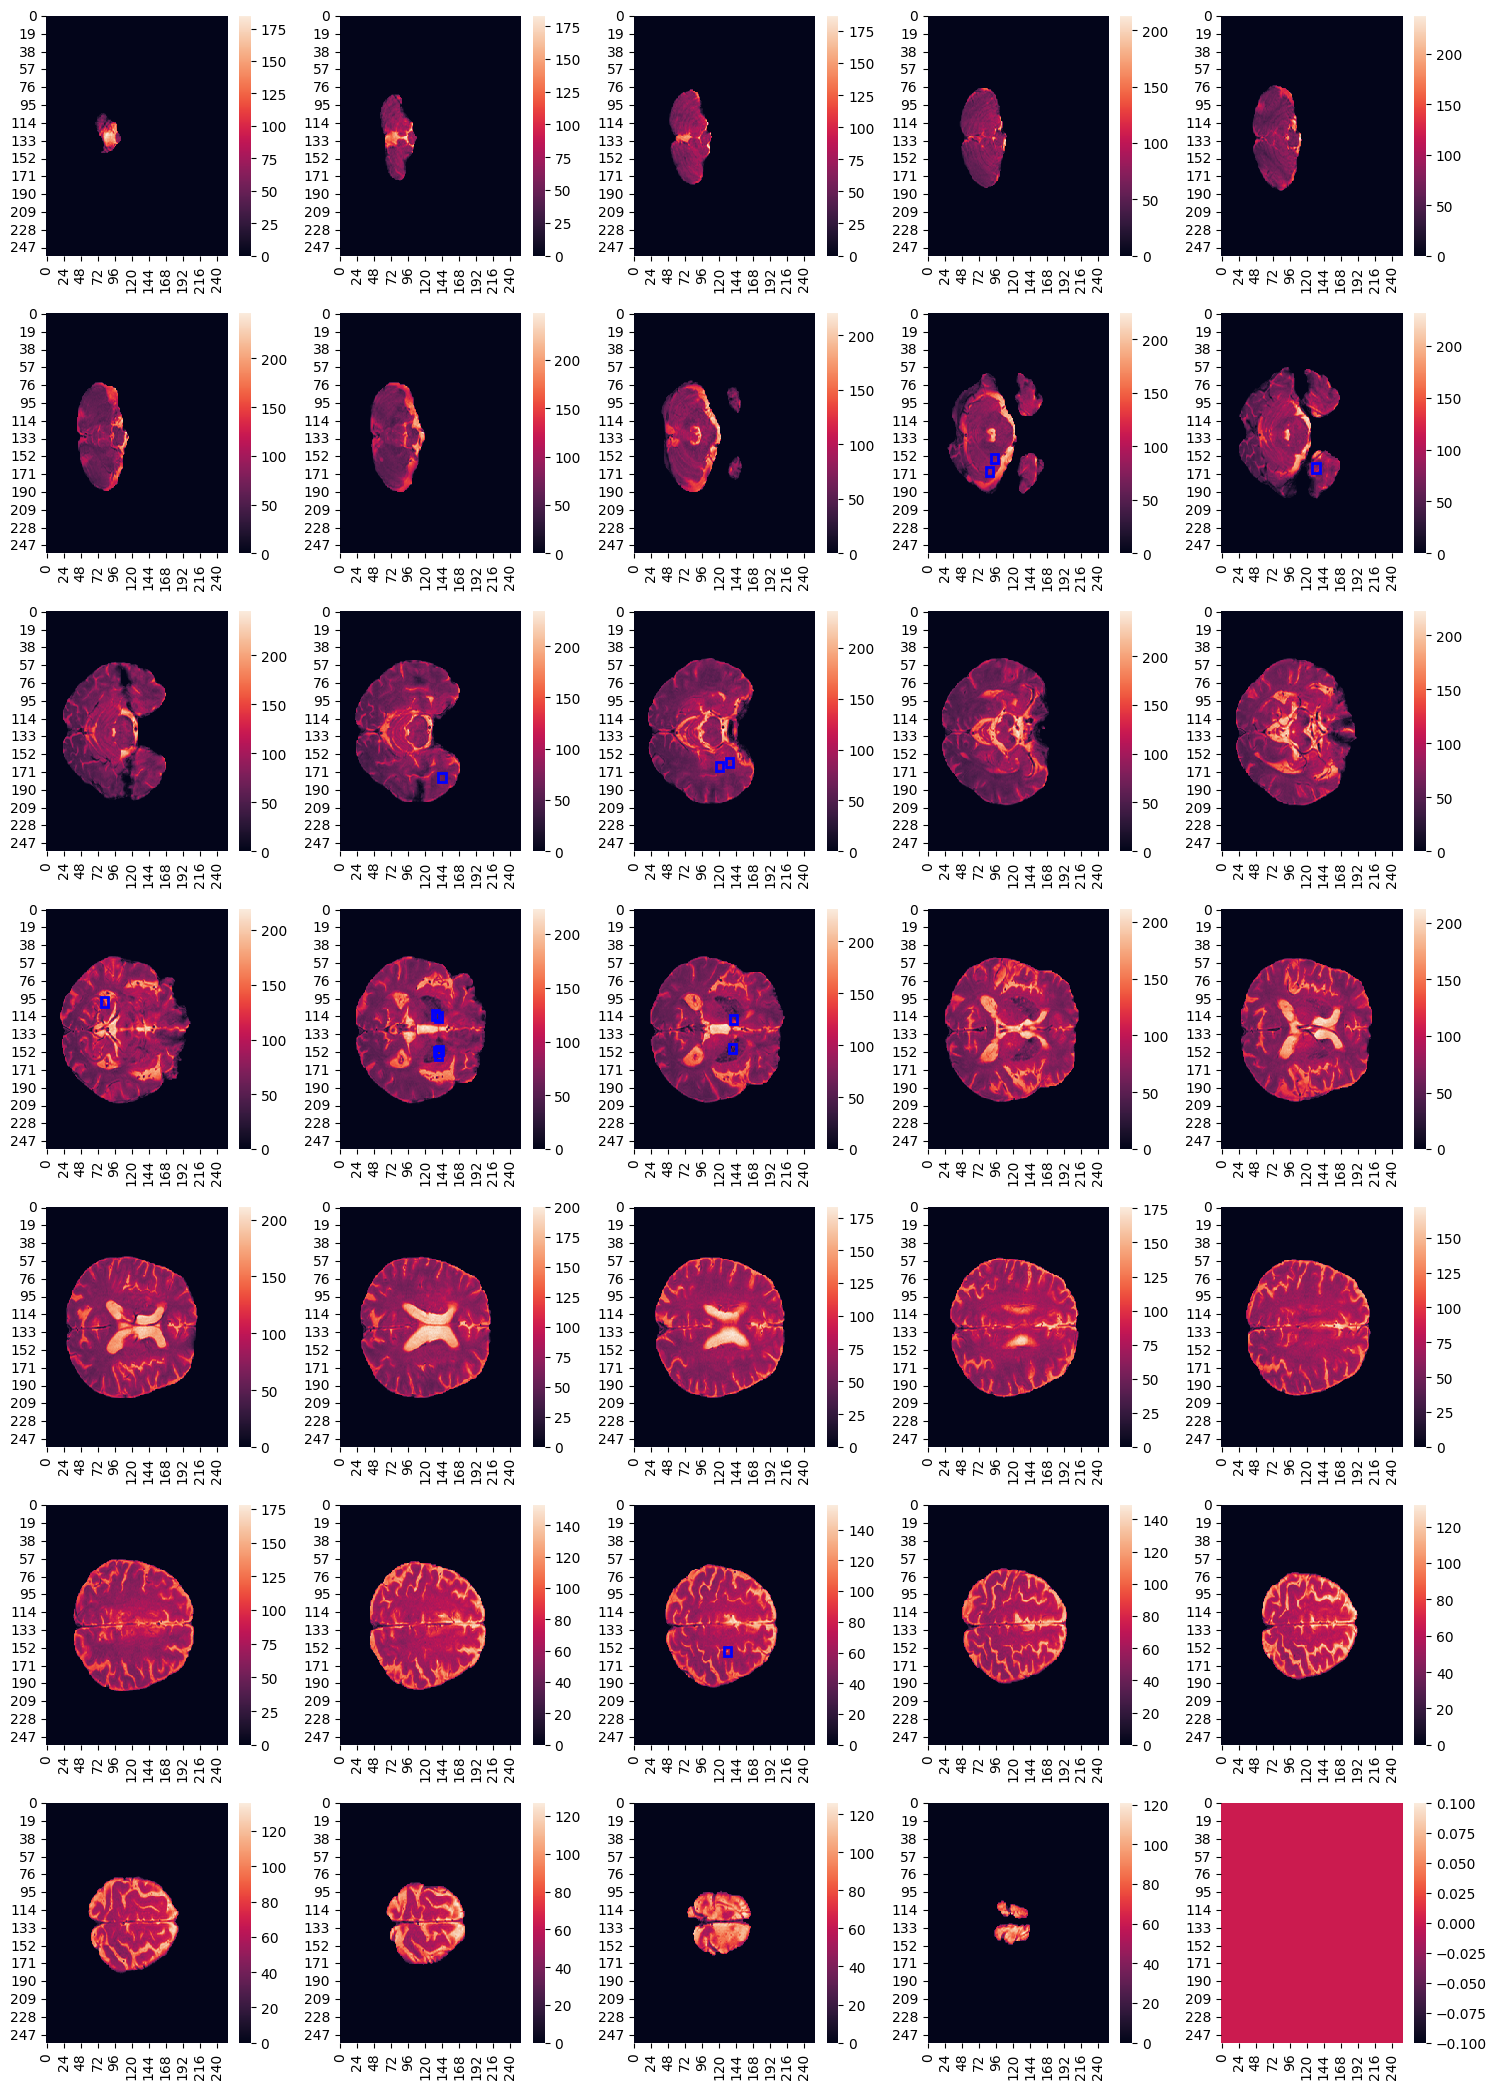

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy

# Assuming you have defined `targets` and `slices` elsewhere in your code
slices, targets, id = dataset[0]
# Calculate the number of subplots needed based on the length of your data
num_slices = len(slices)
num_cols = 5
num_rows = (num_slices + num_cols - 1) // num_cols  # Round up to the nearest integer

# Create the subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))
print(targets[8]['boxes'])
# Iterate over slices and targets
for idx, (slice_base, target) in enumerate(zip(slices, targets)):
    row = idx // num_cols
    col = idx % num_cols
    ax = axes[row, col]

    # Generate heatmap
    heatmap_data = torch.mean(slice_base.float(), dim=0)
    heatmap_data_np = heatmap_data.numpy()
    sns.heatmap(heatmap_data_np, ax=ax)

    # Generate bounding box
    print(idx)
    boxes = predicted_boxes[idx]
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                    linewidth=2, edgecolor='g', facecolor='none'))
    
    boxes = target['boxes']
    for box in boxes:
        x_min, y_min, x_max, y_max = box
        ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, 
                                    linewidth=2, edgecolor='b', facecolor='none'))
    

plt.tight_layout()
plt.show()